# Case Study

## Clustering Travel Agency Booking Data

## Scenario

Suppose you are a data scientist at the Travel Agency, and you are assigned to do Customer Segmentation with the available data.
This assumes not only running clustering but also interpreting the results and providing actionable insights.




In [44]:
# Import packages
import pandas as pd
import numpy as np
import statsmodels as sm
import pylab as pl
from scipy import stats
from sklearn import preprocessing
from sklearn import cluster, tree, decomposition
import matplotlib.pyplot as plt
import pydot
import seaborn as sns
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [18]:
# Loading data
file_name = "data/travel.csv"
travel = pd.read_csv(file_name, parse_dates=['srch_ci','date_time','srch_co'])

In [19]:
pd.set_option('display.max_columns', None)

travel.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-11-03 16:02:00,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68
1,2013-03-13 19:25:00,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37
2,2014-10-13 13:20:00,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22
3,2013-11-05 10:40:00,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42
4,2014-06-10 13:34:00,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83


In [20]:
# Preview our data
print('Number of Rows: {}'.format(travel.shape[0]))

Number of Rows: 100000


## Dataset size

In [21]:
# Get some base information on our dataset
print ("Rows:   " , travel.shape[0])
print ("Columns: " , travel.shape[1])

Rows:    100000
Columns:  24


## Missing Values

As we can see `orig_destination_distance` column has a large amount of missing values. Taking into account, that we cannot infer anything from other features, we will simply remove the feature from further analysis.

In [22]:
# Get statistics for our Numerical Columns
travel.isnull().sum()

date_time                        0
site_name                        0
posa_continent                   0
user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance    36085
user_id                          0
is_mobile                        0
is_package                       0
channel                          0
srch_ci                        122
srch_co                        122
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
srch_destination_type_id         0
is_booking                       0
cnt                              0
hotel_continent                  0
hotel_country                    0
hotel_market                     0
hotel_cluster                    0
dtype: int64

## Correlation Matrix

Let's see whic features are correlated. First we should build `corr` object and then visualize using heatmap from `seaborn`.

**What could you infer?**

In [23]:
# Create our Corelation Matrix
corr = travel.corr()

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

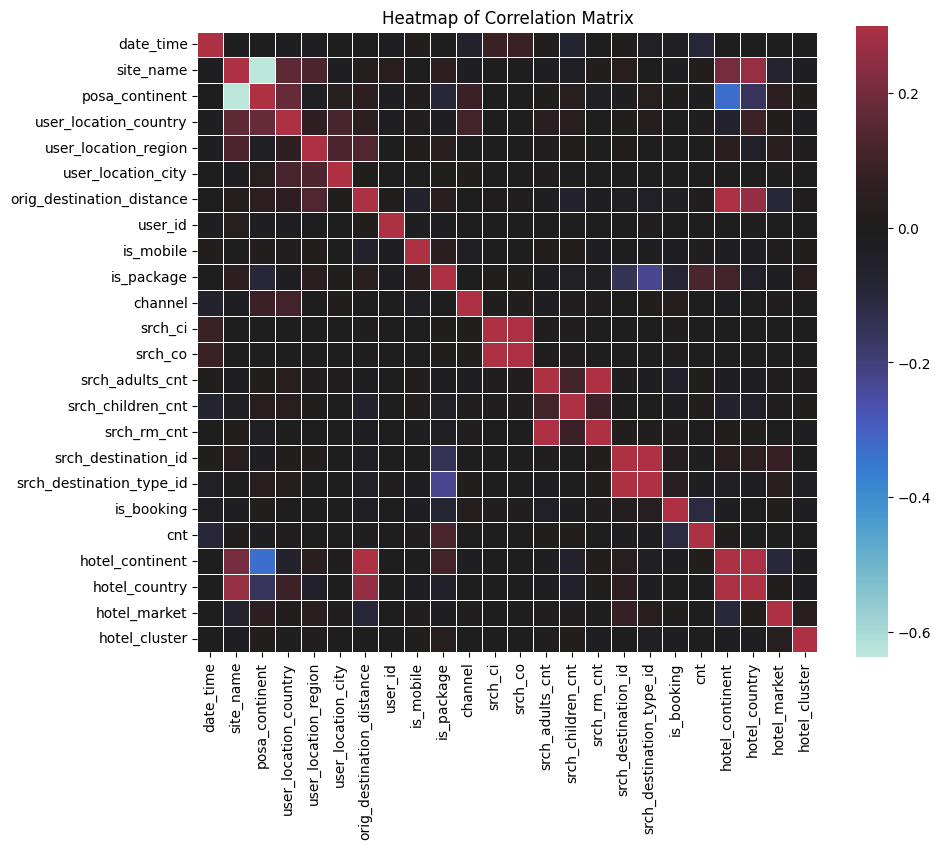

In [24]:
# Generate our corelation plot or heatmap
plt.figure(figsize = (10,10))

sns.heatmap(corr,xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

## Distributions

What could you say about this?

array([[<Axes: title={'center': 'channel'}>,
        <Axes: title={'center': 'is_booking'}>,
        <Axes: title={'center': 'is_mobile'}>],
       [<Axes: title={'center': 'orig_destination_distance'}>,
        <Axes: title={'center': 'srch_rm_cnt'}>,
        <Axes: title={'center': 'srch_adults_cnt'}>],
       [<Axes: title={'center': 'srch_children_cnt'}>, <Axes: >,
        <Axes: >]], dtype=object)

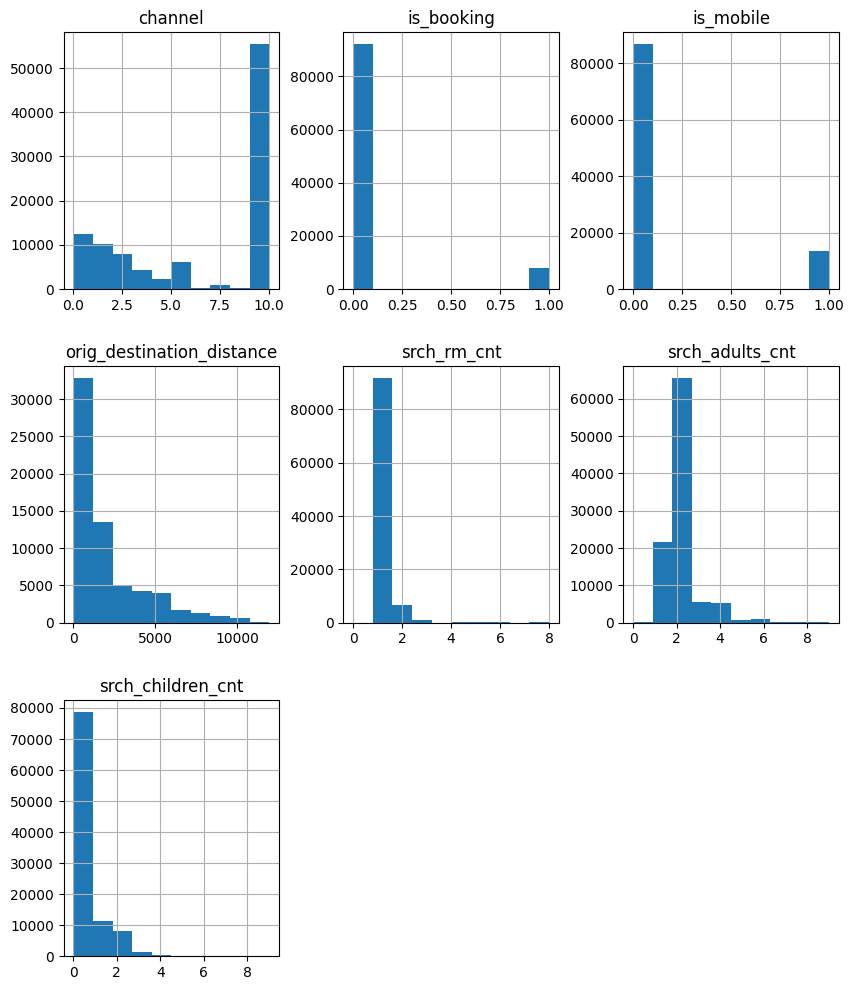

In [24]:
# Plot some of the data
travel[['channel', 'is_booking', 'is_mobile', 'orig_destination_distance',
        'srch_rm_cnt', 'srch_adults_cnt', 'srch_children_cnt']].hist(figsize=(10,12))

In [25]:
travel.groupby('user_id')['is_booking'].agg(num_of_bookings='count')

,num_of_bookings
user_id,
14,1
38,1
40,1
156,2
160,1
...,...
1198722,1
1198742,1
1198748,1


Enriching the dataset with new feature.

#### Visualizing the above output

In [26]:
# To view the bookings made per user
booking_count_per_user=travel.groupby('user_id')['is_booking'].agg(num_of_bookings='count').reset_index()
booking_count_per_user.groupby('num_of_bookings')['user_id'].agg('count')

num_of_bookings
1    79189
2     8423
3     1065
4      161
5       24
6        1
Name: user_id, dtype: int64

array([[<Axes: title={'center': 'num_of_bookings'}>]], dtype=object)

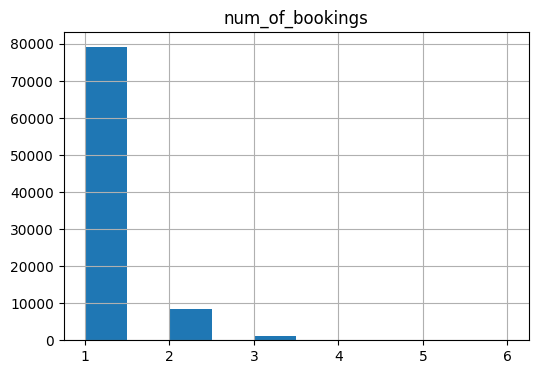

In [27]:
booking_count_per_user[['num_of_bookings']].hist(figsize=(6,4))

In [28]:
# Merge this with our original dataframe to add our 'count' column
travel = travel.merge(travel.groupby('user_id')['is_booking'].agg(['count']).reset_index())
travel.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,count
0,2014-11-03 16:02:00,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2
1,2014-07-28 23:50:00,24,2,77,871,36643,454.4611,792280,0,1,9,2014-08-26,2014-08-31,1,0,1,8286,1,0,1,0,63,1258,14,2
2,2013-03-13 19:25:00,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37,1
3,2014-10-13 13:20:00,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,1
4,2013-11-05 10:40:00,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2


# Logical checks

Remember, Data Scinetists cannot take data and immidetly start modeling. It is expected from the data professioanl to acquire domain knowledge.

Taking into account that number of travelers should be greater then 0, we must remove 174 cases fro the data. Let's drop such cases.


In [29]:
# We use crosstab to group the counts
pd.crosstab(travel['srch_adults_cnt'], travel['srch_children_cnt'])

srch_children_cnt,0,1,2,3,4,5,6,7,8,9
srch_adults_cnt,,,,,,,,,,
0,174,2,3,2,0,0,0,0,0,0
1,18749,2137,523,117,11,1,9,1,2,0
2,50736,7093,6529,972,208,14,7,1,0,0
3,3645,1131,469,131,27,5,2,2,0,2
4,3933,690,494,77,83,9,4,0,0,0
5,535,131,41,20,6,4,2,0,0,0
6,669,73,53,28,18,13,7,0,0,0
7,99,20,5,8,6,3,0,0,0,0
8,183,12,13,2,6,1,3,2,2,1


In [30]:
# Then we sum the counts of travellers and drop the rows that area equal to zero
travel.drop(travel[travel['srch_adults_cnt'] + travel['srch_children_cnt']==0].index).shape

(99826, 25)

## Dates

Converting string objects into datatime objects. And creating new **date** column from **date_time.**

The chronology: Booking $\rightarrow$ Check-In $\rightarrow$ Check-out

- Check-out date need to be later than check-in date
- Check-in date need to be later than booking date

In [31]:
# Changing the column type to  datatime type using pandas
travel['srch_co'] = pd.to_datetime(travel['srch_co'])
travel['srch_ci'] = pd.to_datetime(travel['srch_ci'])
travel['date_time'] = pd.to_datetime(travel['date_time'])

# Change the timestamp of 'date_time' (2014-11-03 16:02:28) to simply "2014-11-03"
travel['date'] = pd.to_datetime(travel['date_time'].apply(lambda x: x.date()))

travel.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,count,date
0,2014-11-03 16:02:00,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2,2014-11-03
1,2014-07-28 23:50:00,24,2,77,871,36643,454.4611,792280,0,1,9,2014-08-26,2014-08-31,1,0,1,8286,1,0,1,0,63,1258,14,2,2014-07-28
2,2013-03-13 19:25:00,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37,1,2013-03-13
3,2014-10-13 13:20:00,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,1,2014-10-13
4,2013-11-05 10:40:00,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2,2013-11-05


In [32]:
travel[travel['srch_co'] < travel['srch_ci']][['srch_co', 'srch_ci']]
travel[travel['srch_ci'] < travel['date']][['srch_ci', 'date']]

,srch_ci,date
7138,2014-01-05,2014-01-07
14931,2014-10-13,2014-10-14
18778,2014-06-11,2014-11-10
22722,2014-02-11,2014-10-09
25886,2014-03-10,2014-09-15
26795,2014-09-12,2014-12-02
29591,2014-08-02,2014-08-23
33886,2013-01-16,2013-01-17
33887,2014-03-03,2014-03-04
33888,2013-01-21,2013-01-22


#### Feature Engineering

Let's create two important (at least from business perspective) features from existing date columns, by applying `duration()` functio: 
- `duration`
- `days_in_advance`

In [33]:
def duration(row,start, end):
    delta=(row[end]-row[start])/np.timedelta64(1,'D')
    if delta<=0:
        return np.nan
    else:
        return delta

In [34]:
# Duration is finds the length of stay by substracting the checkout day from the checkin day
travel['duration'] = travel.apply(duration, args=('srch_ci','srch_co'),axis=1)

# Shows how long in advance the booking was made. Done by substracting the checkin date from the booking date
travel['days_in_advance'] = travel.apply(duration,args=('date','srch_ci'), axis=1)

In [35]:
travel.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,count,date,duration,days_in_advance
0,2014-11-03 16:02:00,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2,2014-11-03,4.0,42.0
1,2014-07-28 23:50:00,24,2,77,871,36643,454.4611,792280,0,1,9,2014-08-26,2014-08-31,1,0,1,8286,1,0,1,0,63,1258,14,2,2014-07-28,5.0,29.0
2,2013-03-13 19:25:00,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37,1,2013-03-13,1.0,NaN
3,2014-10-13 13:20:00,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,1,2014-10-13,7.0,172.0
4,2013-11-05 10:40:00,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2,2013-11-05,1.0,2.0


### Statistical Analysis of Booking Channels

Let's look at how each channel performs by seeing the booking rate for each channel type.

`booking rate` per `channel`

In [36]:
travel.groupby('channel')['is_booking'].agg(booking_rate= 'mean', num_of_bookings= 'count').reset_index().sort_values(by='channel')

,channel,booking_rate,num_of_bookings
0,0,0.071948,12523
1,1,0.069690,10274
2,2,0.060490,7836
3,3,0.060400,4404
4,4,0.120784,2194
5,5,0.094349,6158
6,6,0.067901,162
7,7,0.043157,811
8,8,0.055351,271
9,9,0.085381,55352



# Clustering

Let's choose some features using our business domain knowledge and explore these. After selecting features, let's create two new dataframes with our new data called:

- `df_clustering`
- `df_clustering_groups` grouped by `user_location_city`

**Note:** you're free to add and remove


In [37]:
# Our selected features
features_to_explore = ['duration', 'days_in_advance', 'orig_destination_distance', 'is_mobile',
            'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']


df_clustering = travel[features_to_explore + ['user_location_city']]
df_clustering_groups = df_clustering.groupby('user_location_city').mean().reset_index().dropna(axis=0)

In [38]:
df_clustering.head()

,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,user_location_city
0,4.0,42.0,456.1151,0,1,2,0,1,36643
1,5.0,29.0,454.4611,0,1,1,0,1,36643
2,1.0,NaN,232.4737,0,0,2,0,1,38749
3,7.0,172.0,4468.2720,0,1,2,0,1,48562
4,1.0,2.0,171.6021,0,0,2,0,1,52752


In [39]:
df_clustering.shape

(100000, 9)

In [40]:
df_clustering_groups.head()

,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
0,0,2.0000,78.500000,2315.836250,0.000000,0.250000,1.750000,0.000000,1.0
2,3,4.5625,87.705882,3451.384159,0.058824,0.294118,1.941176,0.470588,1.0
3,7,14.0000,58.000000,5994.864000,0.000000,1.000000,2.000000,0.000000,1.0
5,14,7.0000,35.750000,5342.819100,0.000000,0.000000,2.000000,0.750000,1.0
8,21,5.0000,31.500000,2165.768900,0.000000,0.500000,1.500000,1.000000,1.0


In [41]:
df_clustering_groups.shape

(4483, 9)

# Step 2: Standardizing our data

Let's keep copy `df_clustering_groups` dataset, in order to keep the original one for post-analysis.

In [42]:
df_clustering_std = df_clustering_groups.copy()

df_clustering_std[features_to_explore] = preprocessing.scale(df_clustering_std[features_to_explore])

df_clustering_std.head()

,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
0,0,-0.688726,0.444634,0.313666,-0.621296,-0.028903,-0.502143,-0.704130,-0.331343
2,3,0.563500,0.648714,1.019360,-0.347906,0.119627,-0.199541,0.202478,-0.331343
3,7,5.175361,-0.009819,2.600021,-0.621296,2.496096,-0.106432,-0.704130,-0.331343
5,14,1.754643,-0.503066,2.194804,-0.621296,-0.870569,-0.106432,0.740777,-0.331343
8,21,0.777295,-0.597282,0.220406,-0.621296,0.812763,-0.897855,1.222413,-0.331343


# Step 3: Implement clustering via K-means

Let's start K-means clustering and initially select K=3!
Creating `cluster` column for the same dataset

In [45]:
km = cluster.KMeans(n_clusters=3, max_iter=300, random_state=123)
df_clustering_std['cluster'] = km.fit_predict(df_clustering_std[features_to_explore])

### How do Visualize the result of the clustering?

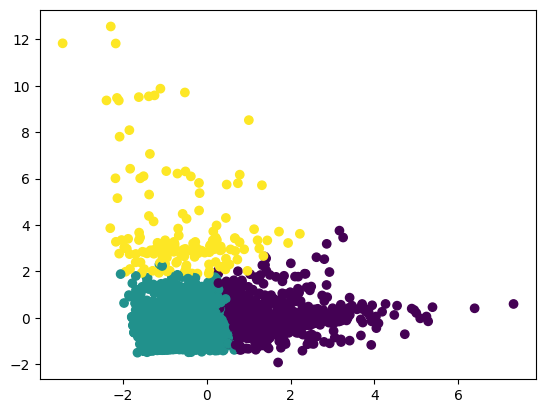

In [46]:
# Principal Component Analysis for Visualization
pca = decomposition.PCA(n_components=2, whiten=True)
#pca.fit(city_groups[features_to_explore])
df_clustering_std['x'] = pca.fit_transform(df_clustering_std[features_to_explore])[:, 0]
df_clustering_std['y'] = pca.fit_transform(df_clustering_std[features_to_explore])[:, 1]
plt.scatter(df_clustering_std['x'], df_clustering_std['y'], c=df_clustering_std['cluster'])
plt.show()

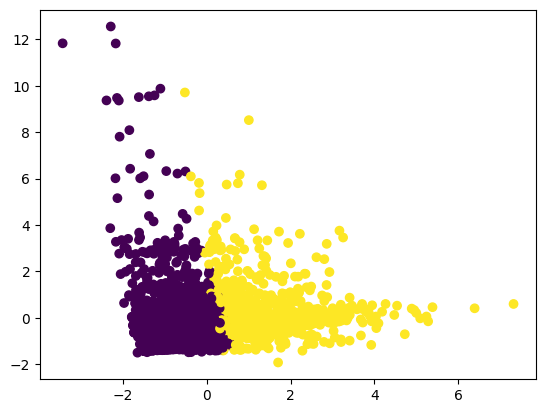

In [54]:
#Let's try it now with 2 clusters

km = cluster.KMeans(n_clusters=2, max_iter=300, random_state=None)
df_clustering_std['cluster'] = km.fit_predict(df_clustering_std[features_to_explore])

# Principal Component Analysis for Visualization
pca = decomposition.PCA(n_components=2, whiten=True)
df_clustering_std['x'] = pca.fit_transform(df_clustering_std[features_to_explore])[:, 0]
df_clustering_std['y'] = pca.fit_transform(df_clustering_std[features_to_explore])[:, 1]
plt.scatter(df_clustering_std['x'], df_clustering_std['y'], c=df_clustering_std['cluster'])
plt.show()

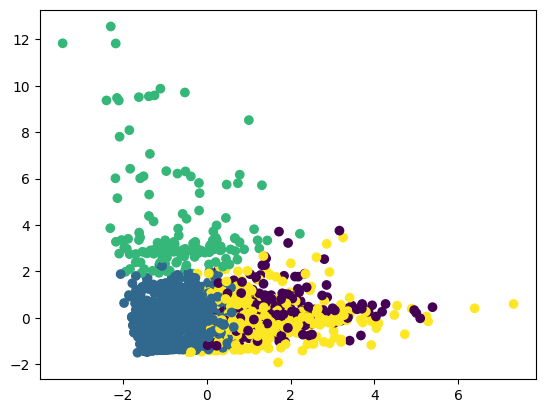

In [47]:
# Now with 4
km = cluster.KMeans(n_clusters=4, max_iter=300, random_state=None)
df_clustering_std['cluster'] = km.fit_predict(df_clustering_std[features_to_explore])

# Principal Component Analysis for Visualization
pca = decomposition.PCA(n_components=2, whiten=True)
df_clustering_std['x'] = pca.fit_transform(df_clustering_std[features_to_explore])[:, 0]
df_clustering_std['y'] = pca.fit_transform(df_clustering_std[features_to_explore])[:, 1]
plt.scatter(df_clustering_std['x'], df_clustering_std['y'], c=df_clustering_std['cluster'])
plt.show()

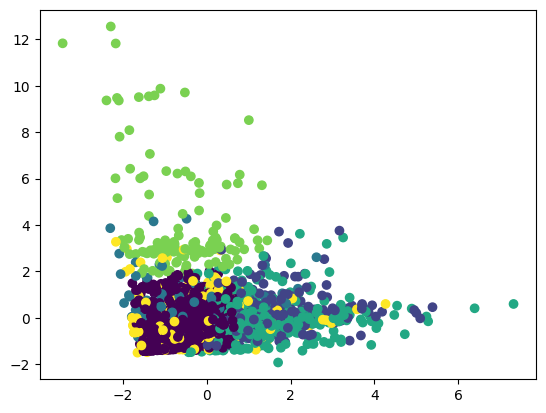

In [48]:
# Now with 6

km = cluster.KMeans(n_clusters=6, max_iter=300, random_state=None)
df_clustering_std['cluster'] = km.fit_predict(df_clustering_std[features_to_explore])

# Principal Component Analysis for Visualization
pca = decomposition.PCA(n_components=2, whiten=True)
df_clustering_std['x'] = pca.fit_transform(df_clustering_std[features_to_explore])[:, 0]
df_clustering_std['y'] = pca.fit_transform(df_clustering_std[features_to_explore])[:, 1]
plt.scatter(df_clustering_std['x'], df_clustering_std['y'], c=df_clustering_std['cluster'])
plt.show()

# Optimal number of clusters

Two find the optimal number of clusters we can user below two methods:

- Elbow Method
- Silhouette Coefficient

# Let's attempt to use the Elbow Method

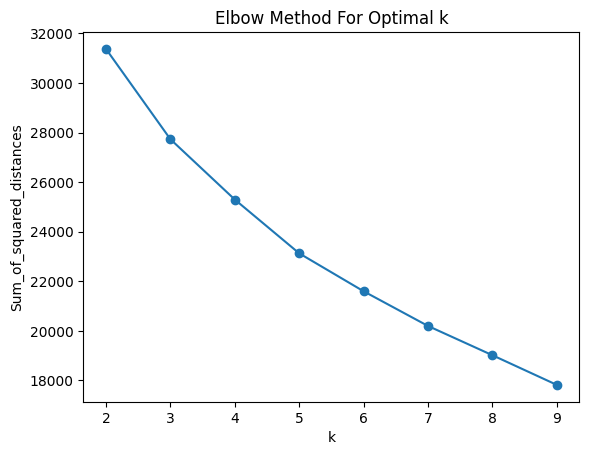

In [49]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []

# Use k from 1 to 15
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=300, random_state=None)
    km = km.fit(df_clustering_std[features_to_explore])
    # Get sum of square distances by applying km.inertia_ 
    Sum_of_squared_distances.append(km.inertia_)

# Plot Results
plt.plot(K, Sum_of_squared_distances, marker='o')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Let's try to use the Silhouette Coefficient

In [50]:
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.cluster import KMeans

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(df_clustering_std[features_to_explore])
    label = kmeans.labels_
    sil_coeff = silhouette_score(df_clustering_std[features_to_explore], label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.22804101675677566
For n_clusters=3, The Silhouette Coefficient is 0.26963792716218826
For n_clusters=4, The Silhouette Coefficient is 0.24430129001703535
For n_clusters=5, The Silhouette Coefficient is 0.2550467758933517
For n_clusters=6, The Silhouette Coefficient is 0.149246454359481
For n_clusters=7, The Silhouette Coefficient is 0.15424841192516872
For n_clusters=8, The Silhouette Coefficient is 0.16476168589854784
For n_clusters=9, The Silhouette Coefficient is 0.16709833326874074
For n_clusters=10, The Silhouette Coefficient is 0.17662671509026104


# Let's stick with K=3

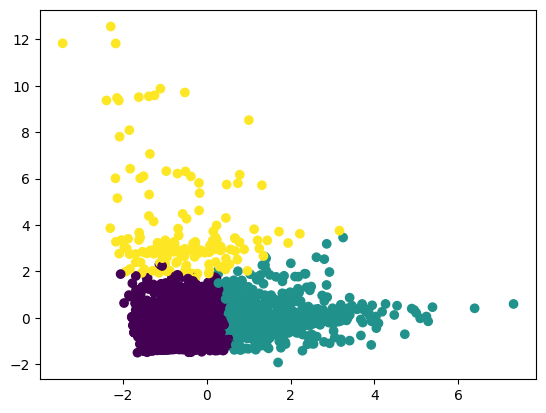

In [51]:
km = cluster.KMeans(n_clusters=3, max_iter=300, random_state=None)
df_clustering_std['cluster'] = km.fit_predict(df_clustering_std[features_to_explore])

# Principal Component Analysis for Visualization
pca = decomposition.PCA(n_components=2, whiten=True)
pca.fit(df_clustering_std[features_to_explore])
df_clustering_std['x'] = pca.fit_transform(df_clustering_std[features_to_explore])[:, 0]
df_clustering_std['y'] = pca.fit_transform(df_clustering_std[features_to_explore])[:, 1]
plt.scatter(df_clustering_std['x'], df_clustering_std['y'], c=df_clustering_std['cluster'])
plt.show()

# Step 4: Profile and Inspect our 3 clusters

In [52]:
# We will merge the two dataframes based on a common column user_location_city
df_clustering.merge(df_clustering_std[['user_location_city', 'cluster']]).groupby('cluster').mean() # for every column

,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,user_location_city
cluster,,,,,,,,,
0,3.186969,52.273648,1809.729645,0.138451,0.235058,2.026611,0.353672,1.097546,28012.103429
1,4.485058,86.595650,3334.557763,0.128036,0.358237,2.035111,0.338569,1.102957,28083.269271
2,3.232000,59.189516,1584.538118,0.104000,0.208000,3.864000,0.516000,2.312000,30540.652000


In [53]:
list(df_clustering.merge(df_clustering_std[['user_location_city', 'cluster']]).groupby('cluster').mean().columns)

['duration',
 'days_in_advance',
 'orig_destination_distance',
 'is_mobile',
 'is_package',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'user_location_city']

# Segmentation

**Group Number:** YourNumber 